In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Load data

In [2]:
df = pd.read_csv('data/mpg.csv')
df.shape

(398, 9)

In [3]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8.0,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8.0,350.0,NaN,3693,11.5,70,1,buick skylark 320
2,18.0,8.0,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8.0,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8.0,302.0,140,3449,10.5,70,1,ford torino


### Distribution of target variable

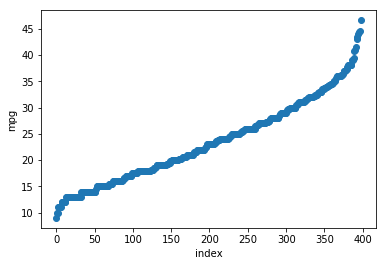

In [4]:
plt.scatter(range(df.shape[0]), np.sort(df['mpg'].values))
plt.xlabel('index')
plt.ylabel('mpg')
plt.show()

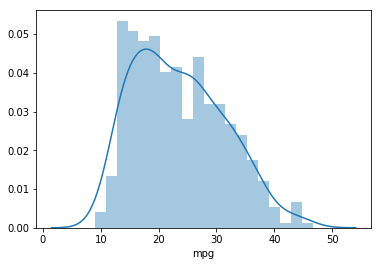

In [5]:
sns.distplot(df['mpg'], bins= 20, kde=True)
plt.show()

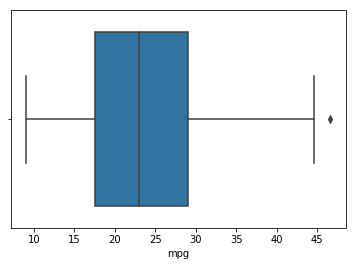

In [6]:
sns.boxplot(x=df['mpg'])
plt.show()

### Clean Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       396 non-null float64
displacement    398 non-null float64
horsepower      397 non-null object
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
name            398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [8]:
# horsepower coded as an object. typically means some weird values ('?')
df.loc[df['horsepower']== '?', 'horsepower'] = None
df['horsepower'] = df['horsepower'].apply(pd.to_numeric)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       396 non-null float64
displacement    398 non-null float64
horsepower      391 non-null float64
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
name            398 non-null object
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [9]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / df.shape[0]
missing_df

,column_name,missing_count,missing_ratio
0,mpg,0,0.000000
1,cylinders,2,0.005025
2,displacement,0,0.000000
3,horsepower,7,0.017588
4,weight,0,0.000000
5,acceleration,0,0.000000
6,model_year,0,0.000000
7,origin,0,0.000000
8,name,0,0.000000


In [10]:
# look at rows with missing values
df.loc[df['cylinders'].isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
6,14.0,NaN,454.0,220.0,4354,9.0,70,1,chevrolet impala
23,26.0,NaN,121.0,113.0,2234,12.5,70,2,bmw 2002


In [11]:
# # fill with value (mean, median, mode, etc.)
# df['cylinders'].fillna(df['cylinders'].median(), inplace=True)
# df['horsepower'].fillna(df['horsepower'].mean(), inplace=True)

# # KNN or regression imputation

# or fill all missing values with mean of column
df.fillna(df.mean(axis=0), inplace=True);

### EDA

In [12]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.452020,193.425879,104.314578,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.694627,104.269838,38.077883,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,124.250000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


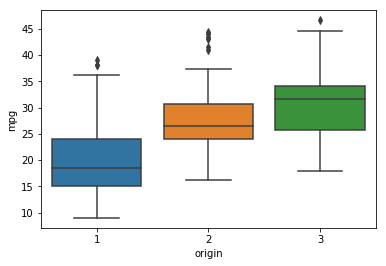

In [13]:
sns.boxplot(x=df['origin'], y=df['mpg'])
plt.show()

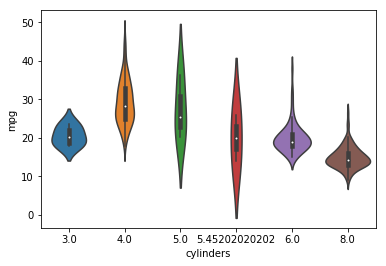

In [14]:
sns.violinplot(x=df['cylinders'], y=df['mpg'])
plt.show()

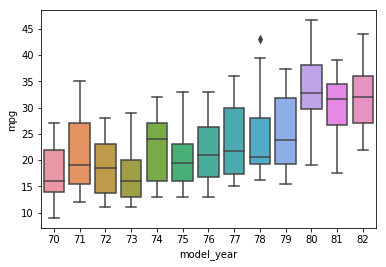

In [15]:
sns.boxplot(x=df['model_year'], y=df['mpg'])
plt.show()

In [16]:
corrmat = df.corr()
corrmat

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
mpg,1.000000,-0.773018,-0.804203,-0.769557,-0.831741,0.420289,0.579267,0.563450
cylinders,-0.773018,1.000000,0.943336,0.827777,0.891324,-0.500702,-0.347410,-0.560806
displacement,-0.804203,0.943336,1.000000,0.890503,0.932824,-0.543684,-0.370164,-0.609409
horsepower,-0.769557,0.827777,0.890503,1.000000,0.859924,-0.680556,-0.406471,-0.452229
weight,-0.831741,0.891324,0.932824,0.859924,1.000000,-0.417457,-0.306564,-0.581024
acceleration,0.420289,-0.500702,-0.543684,-0.680556,-0.417457,1.000000,0.288137,0.205873
model_year,0.579267,-0.347410,-0.370164,-0.406471,-0.306564,0.288137,1.000000,0.180662
origin,0.563450,-0.560806,-0.609409,-0.452229,-0.581024,0.205873,0.180662,1.000000


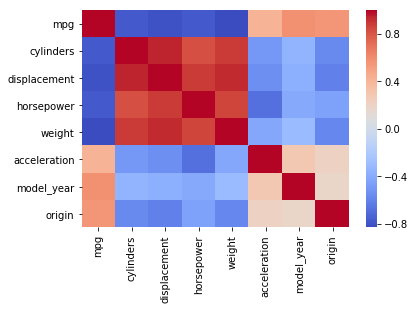

In [17]:
sns.heatmap(corrmat, cmap='coolwarm')
plt.show()

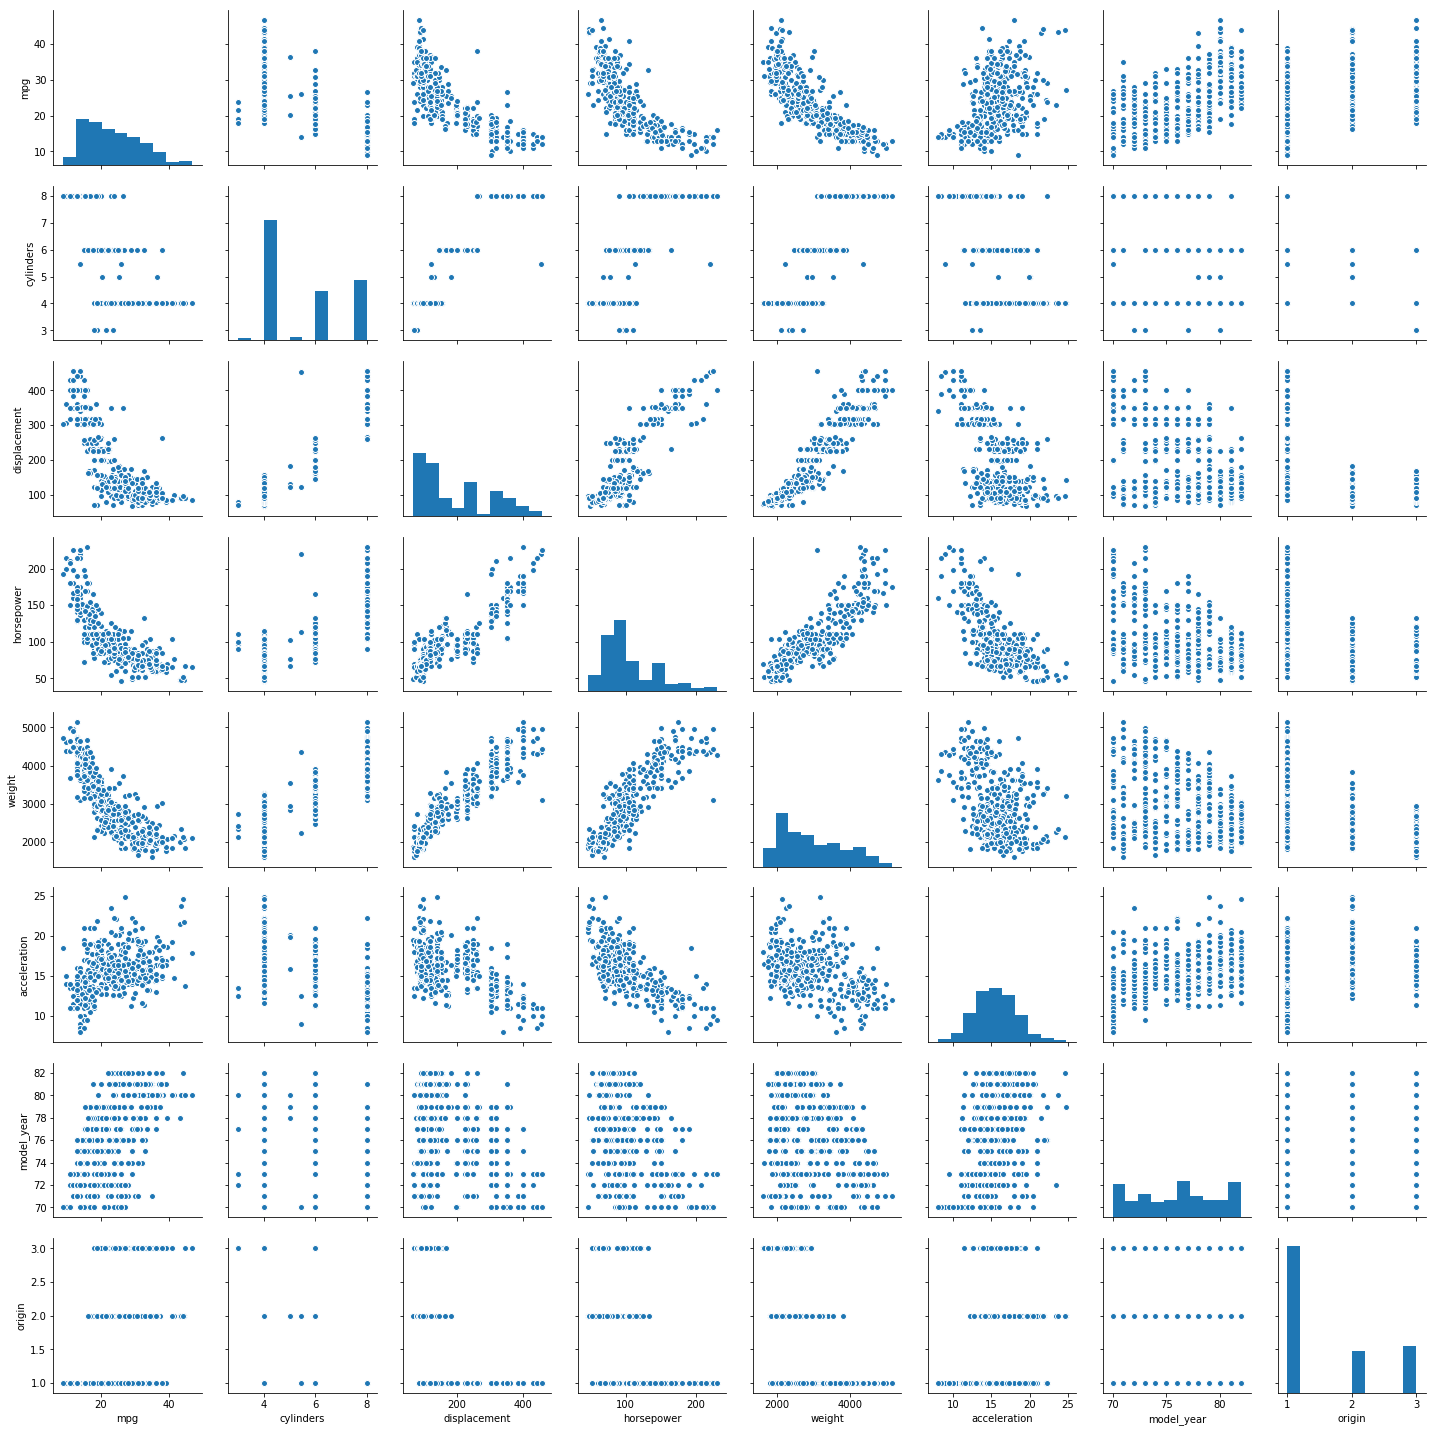

In [18]:
sns.pairplot(df)
plt.show()

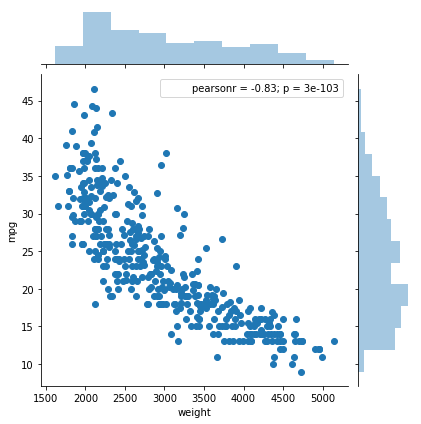

In [19]:
sns.jointplot(x=df['weight'], y=df['mpg'])
plt.show()

### Observations from EDA

1. Target variable fairly normally distributed. Verify residuals are also normally distributed, after fitting model.
2. Some correlations (i.e. weight, horespower) look to be non-linearly correlated with target (mpg). Transformations (feature engineering) likely beneficial.
3. Lots of multicollinearity (cylinders, displacement, horsepower, weight). Regularization will be necessary. 
4. 'Origin' and 'cylinder' variables are categorical.

### Feature Engineering

In [20]:
# Origin (1, 2, 3) to categorical via dummy variables.
origin_dummies = pd.get_dummies(df['origin'], prefix='origin')
origin_dummies.head(3)

,origin_1,origin_2,origin_3
0,1,0,0
1,1,0,0
2,1,0,0


In [21]:
# Origin (1, 2, 3) to categorical via dummy variables.
cylinder_dummies = pd.get_dummies(df['cylinders'], prefix='cylinders')
cylinder_dummies.head(3)

,cylinders_3.0,cylinders_4.0,cylinders_5.0,cylinders_5.45202020202,cylinders_6.0,cylinders_8.0
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,0,1


In [22]:
df = pd.concat([df, origin_dummies.iloc[:, 1:], cylinder_dummies.iloc[:, 1:]], axis=1)
df.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,origin_2,origin_3,cylinders_4.0,cylinders_5.0,cylinders_5.45202020202,cylinders_6.0,cylinders_8.0
0,18.0,8.0,307.0,130.000000,3504,12.0,70,1,chevrolet chevelle malibu,0,0,0,0,0,0,1
1,15.0,8.0,350.0,104.314578,3693,11.5,70,1,buick skylark 320,0,0,0,0,0,0,1
2,18.0,8.0,318.0,150.000000,3436,11.0,70,1,plymouth satellite,0,0,0,0,0,0,1


In [23]:
features = ['cylinders', 'displacement', 'horsepower',
            'weight', 'acceleration', 'model_year', 
            'origin_2', 'origin_3', 'cylinders_4.0',
            'cylinders_5.0', 'cylinders_6.0', 
            'cylinders_8.0']

y = df['mpg']
X = df[features]

### Train test split

In [24]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, ShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

/Users/ky/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

### Model fitting

In [26]:
X_train.head(3)

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_2,origin_3,cylinders_4.0,cylinders_5.0,cylinders_6.0,cylinders_8.0
47,6.0,250.0,100.0,3282,15.0,71,0,0,0,0,1,0
273,4.0,119.0,97.0,2405,14.9,78,0,1,1,0,0,0
58,4.0,97.5,80.0,2126,17.0,72,0,0,1,0,0,0


In [27]:
def rmse_cross_val(model, folds, X_train, y_train):
    '''Implements a shuffled cross val score for RMSE'''
    kf = KFold(n_splits=folds, shuffle=True, random_state=15)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print("Cross validated scores:", rmse_scores)
    print("Avg CV RMSE: %0.2f (+/- %0.2f)" % (rmse_scores.mean(), rmse_scores.std() * 2))

In [28]:
lm = LinearRegression()

rmse_cross_val(lm, 3, X_train[features], y_train)

lm.fit(X_train[features], y_train)
print()
print('feature importances:')
[(col, coef) for col, coef in zip(features, lm.coef_)]

Cross validated scores: [ 3.37915304  3.10785524  3.59324454]
Avg CV RMSE: 3.36 (+/- 0.40)

feature importances:


[('cylinders', 3.0370188450382241),
 ('displacement', 0.012034387644733864),
 ('horsepower', -0.021080451935040156),
 ('weight', -0.0061648079522369503),
 ('acceleration', 0.077799359104028021),
 ('model_year', 0.76361877737143091),
 ('origin_2', 2.0728246989443559),
 ('origin_3', 2.4028490559944533),
 ('cylinders_4.0', 2.1957877365029512),
 ('cylinders_5.0', -0.18629730997825855),
 ('cylinders_6.0', -6.2164129526648662),
 ('cylinders_8.0', -9.8562074108376976)]

### Lasso

In [29]:
lasso = Lasso(alpha=0.5)

# tune with cross val
rmse_cross_val(lasso, 3, X_train[features], y_train)

# evaluate coefficients by fitting to all of data
lasso.fit(X_train[features], y_train)
print()
print('coefficients:')
[(col, coef) for col, coef in zip(features, lasso.coef_)]

Cross validated scores: [ 3.26656464  3.34261328  3.45228825]
Avg CV RMSE: 3.35 (+/- 0.15)

coefficients:


[('cylinders', 0.0),
 ('displacement', -0.0016099418053373304),
 ('horsepower', 0.0),
 ('weight', -0.0064876412638690461),
 ('acceleration', 0.0),
 ('model_year', 0.70419992008318666),
 ('origin_2', 0.0),
 ('origin_3', 0.0),
 ('cylinders_4.0', 0.0),
 ('cylinders_5.0', 0.0),
 ('cylinders_6.0', -0.0),
 ('cylinders_8.0', 0.0)]

### Ridge

In [30]:
ridge = Ridge(alpha=2)

rmse_cross_val(ridge, 3, X_train[features], y_train)

ridge.fit(X_train[features], y_train)
print()
print('coefficients:')
[(col, coef) for col, coef in zip(features, ridge.coef_)]

Cross validated scores: [ 3.17933563  3.11607064  3.40985917]
Avg CV RMSE: 3.24 (+/- 0.25)

coefficients:


[('cylinders', 0.69633418371038203),
 ('displacement', 0.011072464861145607),
 ('horsepower', -0.019828743412342132),
 ('weight', -0.0063095832818841121),
 ('acceleration', 0.08606331261828068),
 ('model_year', 0.76507737277692733),
 ('origin_2', 2.0018133872260009),
 ('origin_3', 2.1189896072687047),
 ('cylinders_4.0', 1.8817080509334376),
 ('cylinders_5.0', 1.1682153327952622),
 ('cylinders_6.0', -1.6586802141041492),
 ('cylinders_8.0', -0.46139399687141341)]

### Random Forest

In [31]:
rf = RandomForestRegressor()

rmse_cross_val(rf, 3, X_train[features], y_train)

rf.fit(X_train[features], y_train)
print()
print('feature importances:')
[(col, feat_importance) for col, feat_importance in zip(features, rf.feature_importances_)]

Cross validated scores: [ 2.34301753  2.90321601  2.68050932]
Avg CV RMSE: 2.64 (+/- 0.46)

feature importances:


[('cylinders', 0.00082532965079576501),
 ('displacement', 0.46187717366612518),
 ('horsepower', 0.10436207374692437),
 ('weight', 0.27649239682622923),
 ('acceleration', 0.028395532311816157),
 ('model_year', 0.12114477106745711),
 ('origin_2', 0.0024697995684738348),
 ('origin_3', 0.0011194120247518945),
 ('cylinders_4.0', 0.00075099901833401662),
 ('cylinders_5.0', 3.5087021804969644e-07),
 ('cylinders_6.0', 0.0018167933502101319),
 ('cylinders_8.0', 0.00074536789866424603)]

From Lasso coefficients and Random Forest feature importances these varibles look to be worth further investgation:
1. displacement
2. weight
3. model year
4. horsepower

In [32]:
df[['mpg', 'displacement', 'weight', 'model_year', 'horsepower']].corr()

,mpg,displacement,weight,model_year,horsepower
mpg,1.000000,-0.804203,-0.831741,0.579267,-0.769557
displacement,-0.804203,1.000000,0.932824,-0.370164,0.890503
weight,-0.831741,0.932824,1.000000,-0.306564,0.859924
model_year,0.579267,-0.370164,-0.306564,1.000000,-0.406471
horsepower,-0.769557,0.890503,0.859924,-0.406471,1.000000


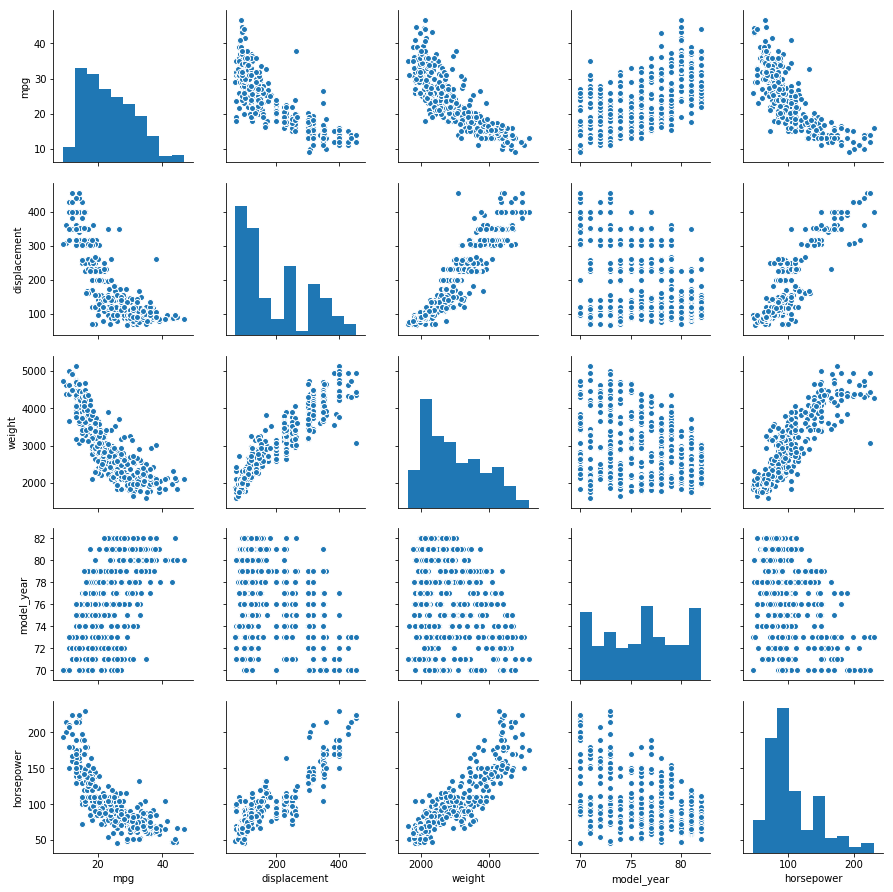

In [33]:
sns.pairplot(df[['mpg', 'displacement', 'weight', 'model_year', 'horsepower']]);

To-do:
1. Bin 'model_year'.
2. Try an inverse transform on 'weight', 'displacement', and 'horsepower'.
3. Power-to-weight ratio.